## Analyze A/B Test Results

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

This project looks at how two version of an e-commerce website converts. We perform some summary statistics, an AB-test as well as logistic regression.

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.

a. Read in the dataset and take a look at the top few rows here:

In [2]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the below cell to find the number of rows in the dataset.

In [3]:
df.shape[0]

294478

c. The number of unique users in the dataset.

In [4]:
df.user_id.nunique()

290584

d. The proportion of users converted.

In [5]:
df.converted.mean()

0.11965919355605512

e. The number of times the `new_page` and `treatment` don't line up.

In [6]:
df.query('group == "treatment" and landing_page != "new_page" or group == "control" and landing_page == "new_page"').count()[0]

3893

f. Do any of the rows have missing values?

In [7]:
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

`2.` For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to provide how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [8]:
df2 = df.query('group == "treatment" and landing_page == "new_page" or group == "control" and landing_page == "old_page"').copy()

In [9]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [10]:
df2.user_id.nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [11]:
df2.user_id.value_counts()[df2.user_id.value_counts() > 1]

773192    2
Name: user_id, dtype: int64

c. What is the row information for the repeat **user_id**? 

In [12]:
df2.query('user_id == 773192')

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [13]:
print(df2.shape)
df2.drop(2893, inplace=True)
print(df2.shape)

(290585, 5)
(290584, 5)


`4.` Use **df2** in the below cells to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [14]:
df2.converted.mean()

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [15]:
df2.query('group == "control"').converted.mean()

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [16]:
df2.query('group == "treatment"').converted.mean()

0.11880806551510564

d. What is the probability that an individual received the new page?

In [17]:
df2.landing_page.value_counts(normalize=True)

new_page    0.500062
old_page    0.499938
Name: landing_page, dtype: float64

e. Consider your results from a. through d. above, and explain below whether you think there is sufficient evidence to say that the new treatment page leads to more conversions.

From what we've seen above, the conversion rate seems to be slightly lower for the new page. The probability of someone converting was during the period 11.96% while the new page got a conversion rate of 11.88% and the old 12.04%. This would suggest that a change to a new design would not help increase conversion rate. However, we have not yet tested for statistically significance.

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

$$ H0: p_{new} - p_{old} ≤ 0 $$
$$ H1: p_{new} - p_{old} > 0 $$

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>


Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **convert rate** for $p_{new}$ under the null? 

In [18]:
p_new = df2.converted.mean()
p_new

0.11959708724499628

b. What is the **convert rate** for $p_{old}$ under the null? <br><br>

In [19]:
p_old = df2.converted.mean()
p_old

0.11959708724499628

c. What is $n_{new}$?

In [20]:
n_new = df2.query('group == "treatment"').count()[0]
n_new

145310

d. What is $n_{old}$?

In [21]:
n_old = df2.query('group == "control"').count()[0]
n_old

145274

e. Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [22]:
new_page_converted = np.random.binomial(1, p_new, n_new).mean()
new_page_converted

0.11997797811575253

f. Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [23]:
old_page_converted = np.random.binomial(1, p_old, n_old).mean()
old_page_converted

0.11951209438715805

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [24]:
new_page_converted - old_page_converted

0.0004658837285944767

h. Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one you calculated in parts **a. through g.** above.  Store all 10,000 values in a numpy array called **p_diffs**.

In [25]:
obs_diff = df2.query('group == "treatment"').converted.mean() - df2.query('group == "control"').converted.mean()

In [26]:
p_diffs = []
for _ in range(10000):
    b_samp_new_page = np.random.binomial(1, p_new, n_new).mean()
    b_samp_old_page = np.random.binomial(1, p_old, n_old).mean()
    p_diffs.append(b_samp_new_page - b_samp_old_page)

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

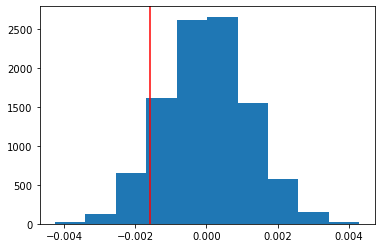

In [27]:
plt.hist(p_diffs)
plt.axvline(x=obs_diff, color='red');

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [28]:
(p_diffs > obs_diff).mean()

0.9016

k. In words, explain what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

**Put your answer here.**

The calculated p-value is in this case is 0.9066, which is much higher than the threshold of 0.05 that was our decided threshold for Type I errors. This means that the null hypothesis cannot be rejected in this case. This indicates that conversion rate of the old page has equal or higher conversion rate than the new one.

The p-value in this situation means that the probability of seeing a value of one that is equal or higher than the observed difference is 90.66% given that the null hypothesis is true.

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [29]:
import statsmodels.api as sm
import scipy

convert_old = df2.query('group == "control"').converted.sum()
convert_new = df2.query('group == "treatment"').converted.sum()
n_old = df2.query('group == "control"').shape[0]
n_new = df2.query('group == "treatment"').shape[0]

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [30]:
z_score, p_val = sm.stats.proportions_ztest([convert_old, convert_new], [n_old, n_new], alternative='larger')
z_score, p_val

(1.3109241984234394, 0.09494168724097551)

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

In [31]:
#critical z-score
scipy.stats.norm.ppf(1-.05)

1.6448536269514722

**Put your answer here.**

The z-score that we computed with the statsmodels z-test function, we got a score of 1.31. This is below the threshold of 1.64 which is the critical value on a 5% significance level. It is a right tailed test since our alternative hypothesis is that the conversion rate of the new page is higher than the old page (the rejection region is to the right). In this case, we fail to reject to null. The P-value from this function also corresponds well to the simulated value that we received (0.9066 vs 0.9051).

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you acheived in the previous A/B test can also be acheived by performing regression.<br><br>

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

Since it's a classification problem of a discrete binary variable (converted or did not convert), the regression type we'll use is a logistic regression.

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives.  However, you first need to create a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [32]:
#adding intercept
df2['intercept'] = 1

In [33]:
df2[['new_page', 'old_page']] = pd.get_dummies(df2['landing_page'])

In [34]:
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,new_page,old_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,1


c. Use **statsmodels** to import your regression model.  Instantiate the model, and fit the model using the two columns you created in part **b.** to predict whether or not an individual converts.

In [35]:
y = df2.converted
X = df2[['intercept', 'new_page']]

logit_model = sm.Logit(y, X)
logit_res = logit_model.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [36]:
logit_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Wed, 24 Mar 2021   Pseudo R-squ.:               8.077e-06
Time:                        16:54:57   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
new_page      -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in the **Part II**?

**Put your answer here.**

The p-value of the new_page coefficient is 0.19, which is higher than 0.05, hence, we cannot reject the null hypothesis. In this case, the null hypothesis is that there is no relationship between the variable and the dependent variable. So whether the new page or the old page is prompted to the user, it does not seem to have an effect on the conversion rate. This is different from the p-value in part II where we wanted to find out whether or not the new page had higher conversion rate than the old page. So it's a two-tailed test in the logistic regression and a one tailed test in the AB-test. 

Below, we can calculate the p-value with the data from the AB-test, this time with a double-sided test to show that we recieve a p-value ≈0.19.

In [37]:
sm.stats.proportions_ztest([convert_old, convert_new], [n_old, n_new])

(1.3109241984234394, 0.18988337448195103)

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

Including other factors would be a good idea, to better understand what is related to conversion as well as how much impact it has on conversion. The ab_page (new_page), was not statistically significant and did not seem to have an affect on whether the user converted or not. However, other variables probably do. One factor to include could be the time component and see if that has any relationship with the conversion rate, for example day/night or weekday/weekend. Disadvantages of adding more terms into the model could be increased complexity as well as multicoleniarity between variables making it more difficult to interpret.

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives. You will need to read in the **countries.csv** dataset and merge together your datasets on the approporiate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [38]:
countries_df = pd.read_csv('./countries.csv')
df_new = countries_df.set_index('user_id').join(df2.set_index('user_id'), how='inner')
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,new_page,old_page
user_id,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,1
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,1
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0


In [39]:
### Create the necessary dummy variables
df_new.country.unique()
df_new[['CA', 'UK', 'US']] = pd.get_dummies(df_new.country)

In [40]:
### Fit Your Linear Model And Obtain the Results
y = df_new.converted
X = df_new[['intercept', 'new_page', 'CA', 'UK']]
logit_model = sm.Logit(y, X)
logit_res = logit_model.fit()
logit_res.summary()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Wed, 24 Mar 2021   Pseudo R-squ.:               2.323e-05
Time:                        16:54:57   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9893      0.009   -223.763      0.000      -2.007      -1.972
new_page      -0.0149      0.011     -1.307      0.191      -0.037       0.007
CA            -0.0408      0.027     -1.516      0.130      -0.093       0.012
UK             0.0099      0.013      0.743      0.457      -0.016       0.036
==============================================================================
"""

In [41]:
1/np.exp(-0.0149), 1/np.exp(-0.0408), np.exp(0.0099)

(1.0150115583846535, 1.0416437559600236, 1.0099491671175422)

The results from the model show that none of the variables are significant predicting the conversion rate of the page. All p-values are above 0.05.

We can take a look at the coefficients still in this example to see what the effects on the conversion rate we could expect if they were significant.

- For every decrease in a user recieving the new page, the likelyhood of conversion increases by 1.5%.
- For every decrease in a CA user in comparison to a US user, the likelyhood of conversion increases by 4.08%.
- For every increase in UK user in comparison to a US user, the likelyhood of conversion increases by 0.99%.

But as stated above, these relationships are insignificant, so we reject these.

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [42]:
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,new_page,old_page,CA,UK,US
user_id,,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,1,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,0,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0,0,1,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,1,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0,0,1,0


In [43]:
df_new['new_page_CA'] = df_new.new_page * df_new.CA
df_new['new_page_UK'] = df_new.new_page * df_new.UK

In [44]:
y = df_new.converted
X = df_new[['intercept', 'new_page', 'CA', 'UK', 'new_page_CA', 'new_page_UK']]

logit_model = sm.Logit(y, X)
logit_results = logit_model.fit()
logit_results.summary()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290578
Method:                           MLE   Df Model:                            5
Date:                Wed, 24 Mar 2021   Pseudo R-squ.:               3.482e-05
Time:                        16:54:58   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1920
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
intercept      -1.9865      0.010   -206.344      0.000      -2.005      -1.968
new_page       -0.0206      0.014     -1.505      0.132      -0.047       0.006
CA             -0.0175      0.038     -0.465      0.642      -0.091       0.056
UK             -0.0057      0.019     -0.306      0.760      -0.043       0.031
new_page_CA    -0.0469      0.054     -0.872      0.383      -0.152       0.059
new_page_UK     0.0314      0.027      1.181      0.238      -0.021       0.084
===============================================================================
"""

In [45]:
1/np.exp(-0.0206), 1/np.exp(-0.0175), 1/np.exp(-0.0057), 1/np.exp(-0.0469), np.exp(0.0314)

(1.020813644503746,
 1.0176540221507617,
 1.0057162759095335,
 1.048017202119183,
 1.0318981806179213)

Also here, none of the the variables included are significant predicting conversion rate, since all the p-values are above the threshold of 0.05.

If we ignore that and look at the exponentials of the coefficients we see that:
- For every new_page shown compared to the old page, it increases the likelyhood of conversion by 2.08%.
- For every CA user instead of a US user, the likelyhood of conversion decreases by 1.76%.
- For every UK user instead of a US user, the likelyhood of conversion decreases by 0.57%.
- For every CA user receiving a new page, compared to a US user receiving the new page, the likelyhood of conversion decreases by 4.69%.
- For every UK users receiving receiving a new page, compared to a US user receiving the new page, the likely hood of conversion increases by 3.18%.

<a id='conclusions'></a>
## Conclusions

The descriptive statistics, simulations, AB-tests and logistic regression models did not give us any evidence showing that the new page converted better, neither did any of our variables show any sign of increasing our conversion rates. This means that we cannot reject the null hypotheis, and the old page seems to be the better choice.